In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
sns.set()

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15

seed = 42

In [2]:
X_train_pars_df = pd.read_csv('X_train_pars_df.csv')
X_test_pars_df = pd.read_csv('X_test_pars_df.csv')

y_train_df = pd.read_csv('y_train.csv')
y_test_df = pd.read_csv('y_test.csv')

In [3]:
class classif_models:
    
    def __init__(self, Xtrain, ytrain, cv):
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.cv = cv
        
    def check_clf_models(self):
    
        from sklearn.pipeline import Pipeline
        from sklearn.preprocessing import StandardScaler

        from sklearn.linear_model import (
            LogisticRegression,
            LogisticRegressionCV,
            SGDClassifier,
            Perceptron,
            PassiveAggressiveClassifier,
            RidgeClassifier, 
            RidgeClassifierCV
        )

        from sklearn.svm import LinearSVC, SVC, NuSVC
        from sklearn.neighbors import KNeighborsClassifier
        from sklearn.naive_bayes import  GaussianNB, BernoulliNB
        from sklearn.neural_network import MLPClassifier
        from sklearn.gaussian_process import GaussianProcessClassifier

        from sklearn import metrics

        models = [
            LogisticRegression(),
            LogisticRegressionCV(cv=5),
            SGDClassifier(tol = 0.1, early_stopping = True, validation_fraction = 0.2),
            Perceptron(tol = 0.1, early_stopping = True, validation_fraction = 0.2),
            PassiveAggressiveClassifier(tol = 0.1, early_stopping = True, validation_fraction = 0.2),
            RidgeClassifier(),
            RidgeClassifierCV(cv=5),
            LinearSVC(loss = 'hinge'),
            SVC(kernel = 'rbf'),
            NuSVC(),
            KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2),
            GaussianNB(), 
            BernoulliNB(),
            MLPClassifier(tol=0.1, early_stopping = True, validation_fraction = 0.2),
            GaussianProcessClassifier()
        ]

        final_f1_score = []
        final_score = []
        final_score_std = []
        final_roc_auc_score = []
        final_mcc_score = []
        model_names = []

        for model in models:
            pipe = Pipeline(steps = [('scaler', StandardScaler()), (type(model).__name__, model)])
            score = [] 
            f1_score = []
            roc_auc_score = []
            mcc_score = []
            fold_no = 1 
            for train_index, test_index in self.cv.split(self.Xtrain, self.ytrain): 
                X_train_kfold, X_val_kfold = self.Xtrain[train_index], self.Xtrain[test_index] 
                y_train_kfold, y_val_kfold = self.ytrain[train_index], self.ytrain[test_index] 
                pipe.fit(X_train_kfold, y_train_kfold) 
                y_pred = pipe.predict(X_val_kfold)
                score.append(metrics.accuracy_score(y_val_kfold, y_pred))
                f1_score.append(metrics.f1_score(y_val_kfold, y_pred))
                mcc_score.append(metrics.matthews_corrcoef(y_val_kfold, y_pred))

                if hasattr(model, "predict_proba"):
                    roc_auc_score.append(metrics.roc_auc_score(y_val_kfold, 
                                                               pipe.predict_proba(X_val_kfold)[:, 1]))
                else: 
                    roc_auc_score.append(metrics.roc_auc_score(y_val_kfold, 
                                                               pipe.decision_function(X_val_kfold)))

                fold_no += 1
            final_score.append(np.round(np.mean(score)*100,3))
            final_score_std.append(np.round(np.std(score)*100,3))
            final_f1_score.append(np.round(np.mean(f1_score)*100,3))
            final_roc_auc_score.append(np.round(np.mean(roc_auc_score)*100,3))
            final_mcc_score.append(np.round(np.mean(mcc_score)*100,3))
            model_names.append(type(model).__name__)

    #Using Ensemble Models

        from sklearn.tree import DecisionTreeClassifier
        from xgboost import XGBClassifier
        from catboost import CatBoostClassifier
        from lightgbm import LGBMClassifier
        from sklearn.experimental import enable_hist_gradient_boosting

        from sklearn.ensemble import (
            RandomForestClassifier, 
            AdaBoostClassifier, 
            GradientBoostingClassifier, 
            ExtraTreesClassifier, 
            IsolationForest, 
            BaggingClassifier, 
            HistGradientBoostingClassifier
        )

        from imblearn.ensemble import (
            EasyEnsembleClassifier, 
            RUSBoostClassifier, 
            BalancedBaggingClassifier, 
            BalancedRandomForestClassifier 
        )

        tree_models = [
            DecisionTreeClassifier(criterion = 'entropy', max_depth = 6),
            RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 6), 
            XGBClassifier(use_label_encoder=False, eval_metric = 'error'), 
            CatBoostClassifier(verbose = False, loss_function='CrossEntropy', eval_metric='TotalF1'), 
            LGBMClassifier(), 
            AdaBoostClassifier(), 
            GradientBoostingClassifier(), 
            BaggingClassifier(), 
            ExtraTreesClassifier(), 
            HistGradientBoostingClassifier(), 
            EasyEnsembleClassifier(), 
            RUSBoostClassifier(), 
            BalancedBaggingClassifier(), 
            BalancedRandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 6)
        ]

        for model in tree_models:
            score = [] 
            f1_score = []
            mcc_score = []
            fold_no = 1 
            for train_index, test_index in self.cv.split(self.Xtrain,self.ytrain): 
                X_train_kfold, X_val_kfold = self.Xtrain[train_index], self.Xtrain[test_index] 
                y_train_kfold, y_val_kfold = self.ytrain[train_index], self.ytrain[test_index] 
                classifier = model 
                classifier.fit(X_train_kfold, y_train_kfold) 
                y_pred = classifier.predict(X_val_kfold)
                
                score.append(metrics.accuracy_score(y_val_kfold, y_pred))
                
                f1_score.append(metrics.f1_score(y_val_kfold, y_pred))
                
                roc_auc_score.append(metrics.roc_auc_score(y_val_kfold, 
                                                           classifier.predict_proba(X_val_kfold)[:, 1]))
                
                mcc_score.append(metrics.matthews_corrcoef(y_val_kfold, y_pred))

                fold_no += 1
            
            final_score.append(np.round(np.mean(score)*100,3))
            final_score_std.append(np.round(np.std(score)*100,3))
            final_f1_score.append(np.round(np.mean(f1_score)*100,3))
            final_roc_auc_score.append(np.round(np.mean(roc_auc_score)*100,3))
            final_mcc_score.append(np.round(np.mean(mcc_score)*100,3))
            model_names.append(type(model).__name__)


        self.df = pd.DataFrame({
                'Models': model_names, 
                'Accuracy %': final_score, 
                'Acc_STD %': final_score_std, 
                'F1_Score %':final_f1_score,
                'ROC_AUC_Score %' :final_roc_auc_score, 
                'MCC_Score %': final_mcc_score
            }).sort_values('F1_Score %', ascending = False, ignore_index = True).style.\
                                                                highlight_max(color = 'green')

        return self.df

In [4]:
class validate_on_test:
    
    def __init__(self, model, Xtrain, ytrain, Xtest, ytest, cv):
        self.model = model
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.Xtest = Xtest
        self.ytest = ytest
        self.cv = cv
        
    def evaluate_model(self):
    
        from sklearn import metrics
        import scikitplot as skplt
        import matplotlib.pyplot as plt

        model_name = type(self.model).__name__
        
        print('================================================')
        print(f'Model: *** {model_name} ***')
        print('================================================')
        print()

        score = []
        fold_no = 1

        for train_index, test_index in self.cv.split(self.Xtrain,self.ytrain):
            print(f'{fold_no} of kfold {self.cv.n_splits}')
            X_train_kfold, X_val_kfold = self.Xtrain[train_index], self.Xtrain[test_index]
            y_train_kfold, y_val_kfold = self.ytrain[train_index], self.ytrain[test_index]

            classifier = self.model

            classifier.fit(X_train_kfold, y_train_kfold) 
            y_pred = classifier.predict(X_val_kfold)
            print(f'Accuracy: {metrics.accuracy_score(y_val_kfold, y_pred)*100} %')
            score.append(metrics.accuracy_score(y_val_kfold, y_pred))
            fold_no += 1
        print()
        print(f'Mean CV Accuracy: {np.round(np.mean(score)*100,3)} ± {np.round(np.std(score)*100,1)} %')
        print()
        print("---" * 40)

        classifier.fit(self.Xtrain,self.ytrain)
        y_pred = classifier.predict(self.Xtest)
        y_probs = classifier.predict_proba(self.Xtest)
        
        self.y_probs = y_probs

        print()
        print('====================================')
        print("Classification report on Test set:")
        print('====================================')
        print()
        print(metrics.classification_report(self.ytest, y_pred))
        print()
        print("---" * 40)
        print()
        print('=============================================================')
        print(f'*** {model_name} scores on TEST set ***')
        print('=============================================================')
        print()
        print(f'** F1 score: {np.round(metrics.f1_score(self.ytest, y_pred)*100,3)} % **')
        print() 
        print(f'** Accuracy: {np.round(metrics.accuracy_score(self.ytest, y_pred)*100,3)} % **')
        print()
        print(f'** ROC AUC Score: {np.round(metrics.roc_auc_score(self.ytest, y_probs[:,1])*100,3)} % **')
        print()
        
        print("---" * 40)
        print()

        # apply threshold to positive probabilities to create labels
        print('Estimating new probability threshold.........Please Wait..............')
        print()
        
        thresholds = np.arange(0, 1, 0.001)

        # apply threshold to positive probabilities to create labels
        def to_labels(pos_probs, threshold):
            return (pos_probs >= threshold).astype('int')

        # evaluate each threshold
        self.scores = [metrics.f1_score(self.ytest, to_labels(self.y_probs[:,1], t)) for t in thresholds]

        # get best threshold
        ix = np.argmax(self.scores)
        
        self.new_prob_threshold = thresholds[ix]
        
        print('** Threshold = %.3f, F-Score = %.3f **' % (thresholds[ix]*100, self.scores[ix]*100))
        print()

        self.tuned_pred = np.where(classifier.predict_proba(self.Xtest)[:,1] >= thresholds[ix],1,0)
        new_acc = metrics.accuracy_score(self.ytest, self.tuned_pred)
        new_f1 = metrics.f1_score(self.ytest, self.tuned_pred)
        
        print('==============================================================')
        print(f'*** New Scores with tuned probability threshold: {np.round(thresholds[ix]*100,3)} % ***')
        print('==============================================================')
        print()
        print(f'{model_name} F1 Score: {np.round(new_f1*100,3)} %')
        print()
        print(f'{model_name} Accuracy: {np.round(new_acc*100,3)} %')
        print()
        print("---" * 40)

        skplt.metrics.plot_roc(self.ytest, y_probs);
        
        print('====================================================')
        print(f'    *** ROC AUC Plot and Confusion Matrix ***')
        print('====================================================')
        
        fig = plt.figure(figsize = (15,5));
        ax1 = fig.add_subplot(121);
        ax2 = fig.add_subplot(122);
        
        skplt.metrics.plot_confusion_matrix(self.ytest, y_pred, ax = ax1, text_fontsize = 'large', 
                                            cmap='YlGn');
    
        
        skplt.metrics.plot_confusion_matrix(self.ytest, self.tuned_pred, ax = ax2, text_fontsize = 'large',
                                            cmap='YlGn');
        
        ax1.title.set_text('With Prob. Threshold = 50 %');
        ax2.title.set_text(f'With New Prob. Threshold = {np.round(thresholds[ix]*100,2)} %');

## Selecting the right Model

In [5]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)

classif_models(X_train_pars_df.values, y_train_df.target.values, cv=skf).check_clf_models()

,Models,Accuracy %,Acc_STD %,F1_Score %,ROC_AUC_Score %,MCC_Score %
0,BalancedRandomForestClassifier,79.325000,3.896000,77.305000,82.551000,58.740000
1,BalancedBaggingClassifier,78.786000,2.914000,75.876000,82.469000,57.254000
2,HistGradientBoostingClassifier,78.604000,3.400000,75.580000,82.721000,56.872000
3,BaggingClassifier,78.789000,3.594000,75.574000,82.665000,57.158000
4,CatBoostClassifier,78.607000,3.821000,75.574000,82.947000,56.849000
5,ExtraTreesClassifier,78.971000,3.333000,75.548000,82.679000,57.464000
6,LGBMClassifier,78.062000,3.618000,75.174000,82.936000,55.776000
7,RandomForestClassifier,78.240000,3.534000,74.965000,82.648000,56.009000
8,XGBClassifier,77.886000,3.243000,74.568000,82.839000,55.330000
9,GaussianProcessClassifier,77.705000,3.756000,74.116000,82.495000,54.944000


Balanced Random Forest Classifier has the highest metrics compared to all other major classification algorithms. Hence, this model will be chosen.

### Hyper Parameter Tuning

We have managed to tune the hyperparameters of the model that can help improve the overall predictability of the model on an unseen dataset, such as the test set.

Best Accuracy: -77.65889909079571 %, Elapsed Time: 4.4 min
Best parameters:
n_estimators=1500, 
criterion='entropy',
max_depth=7,
min_samples_split=0.000, 
min_samples_leaf=1, 
max_features='sqrt', 
ccp_alpha=0.0001, 
bootstrap=False, 
replacement=False, 
class_weight='balanced', 
max_samples=0.520 


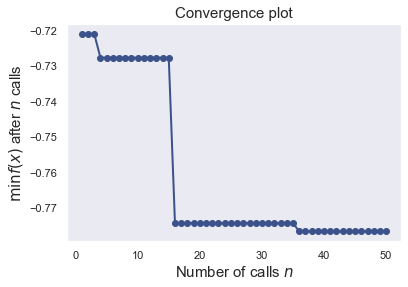

In [9]:
from sklearn.model_selection import cross_val_score

from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical #Real = float
from skopt.utils import use_named_args
import time

param_grid = [
    Integer(10, 1500, name="n_estimators"),
    Categorical(['gini', 'entropy'], name = "criterion"),
    Integer(1,7, name = "max_depth"),
    Real(0.0001, 0.999, name = "min_samples_split"),
    Integer(1,30, name = "min_samples_leaf"),
    Categorical(['sqrt', 'log2'], name = "max_features"),
    Real(0.0001, 0.035, name="ccp_alpha"),
    Categorical([True, False], name = "bootstrap"), 
    Categorical([True, False], name = "replacement"), 
    Categorical(['balanced', 'balanced_subsample'], name = "class_weight"),
    Real(0.1, 0.999, name="max_samples")
]

model = BalancedRandomForestClassifier()

@use_named_args(param_grid)
def objective(**params):
    
    # model with new parameters
    model.set_params(**params)

    # optimization function (hyperparam response function)
    value = np.mean(cross_val_score(model, X_train_pars_df, y_train_df,
                                    cv=StratifiedKFold(n_splits=5, random_state=seed, shuffle=True),
                                    n_jobs=-1, scoring='f1')
                   )

    # negate because we need to minimize
    return -value

start_time = time.time()

gp_ = gp_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    n_initial_points=10, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    n_calls=50, # the number of subsequent evaluations of f(x)
    random_state=seed, 
)

print(f'Best Accuracy: {gp_.fun*100} %, Elapsed Time: {np.round((time.time() - start_time)/60,2)} min')

print("""Best parameters:
=========================
n_estimators=%d, 
criterion='%s',
max_depth=%d,
min_samples_split=%.3f, 
min_samples_leaf=%d, 
max_features='%s', 
ccp_alpha=%.4f, 
bootstrap=%s, 
replacement=%s, 
class_weight='%s', 
max_samples=%.3f """ % (gp_.x[0], gp_.x[1], gp_.x[2], gp_.x[3], gp_.x[4], gp_.x[5], gp_.x[6], gp_.x[7],
                        gp_.x[8], gp_.x[9], gp_.x[10]))

plot_convergence(gp_);

## Model Validation

Here, the train set will be split train and validation set with 10 folds using Stratified cross validation technique, where the train set will run on each fold and then be tested on the validation set to rank its overall accuracy on an unseen set.

After the cross validation, the model will then finally be used to predict on the test set.
Once the model predicts the prbability on the test set, I will look for the optimal threshold level which can further help improve the overall predicatbility and accuracy of the model.

Model: *** BalancedRandomForestClassifier ***

1 of kfold 10
Accuracy: 80.35714285714286 %
2 of kfold 10
Accuracy: 82.14285714285714 %
3 of kfold 10
Accuracy: 73.21428571428571 %
4 of kfold 10
Accuracy: 82.14285714285714 %
5 of kfold 10
Accuracy: 73.21428571428571 %
6 of kfold 10
Accuracy: 83.92857142857143 %
7 of kfold 10
Accuracy: 78.18181818181819 %
8 of kfold 10
Accuracy: 80.0 %
9 of kfold 10
Accuracy: 81.81818181818183 %
10 of kfold 10
Accuracy: 74.54545454545455 %

Mean CV Accuracy: 78.955 ± 3.8 %

------------------------------------------------------------------------------------------------------------------------

Classification report on Test set:

              precision    recall  f1-score   support

           0       0.74      0.83      0.78        30
           1       0.82      0.72      0.77        32

    accuracy                           0.77        62
   macro avg       0.78      0.78      0.77        62
weighted avg       0.78      0.77      0.77        62


----

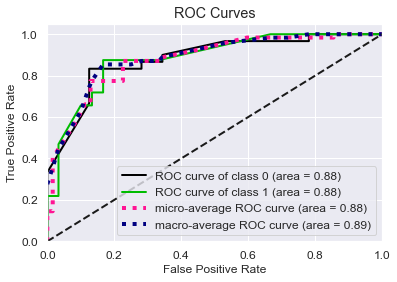

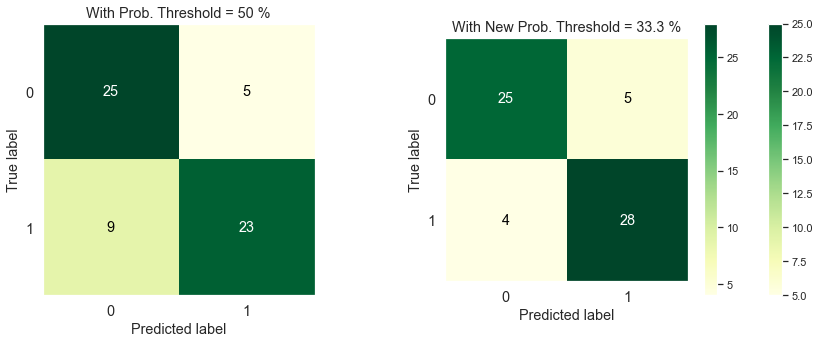

In [6]:
from imblearn.ensemble import BalancedRandomForestClassifier


# chosen_param = OrderedDict([('bootstrap', True), ('ccp_alpha', 0.0), 
#                             ('class_weight', 'balanced_subsample'), ('criterion', 'entropy'), 
#                             ('max_depth', 6), ('max_features', 'log2'), ('max_leaf_nodes', None), 
#                             ('max_samples', 0.8866553367490223), ('min_samples_leaf', 1), 
#                             ('min_samples_split', 0.032412646362337136), ('n_estimators', 1364), 
#                             ('replacement', True)])

brf_new = BalancedRandomForestClassifier(n_estimators=1500, 
                                         criterion="gini",
                                         max_depth=7,
                                         min_samples_split=2, 
                                         min_samples_leaf=6, 
                                         max_features="log2", 
                                         ccp_alpha=0.0001, 
                                         bootstrap=False, 
                                         replacement=True, 
                                         class_weight="balanced", 
                                         max_samples=0.263)#.set_params(**chosen_param)

result = validate_on_test(brf_new, X_train_pars_df.values, y_train_df.target.values, 
               X_test_pars_df.values, y_test_df.target.values, cv=skf)

result.evaluate_model()

As seen above, at first, the accuracy on the test set was 77%, with the probability threshold of 50%. But, the ideal threshold which helps to maximise the F1 score was around 33%. Hence, applying this new threshold, probability higher than 33% will be of class 1 and probability below 33% will be class zero.

This helped significantly improve the overal model accuracy, from 77% accuracy to approximatly 85.4% model accuracy.